In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_25553/2332860251.py:13: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


In [2]:
def trotter_gate(dt, to_instruction = True):
    qc = QuantumCircuit(2)
    qc.rx(2*dt,0)
    qc.rz(2*dt,1)
    qc.h(1)
    qc.cx(1,0)
    qc.rz(-2*dt, 0)
    qc.rx(-2*dt, 1)
    qc.rz(2*dt, 1)
    qc.cx(1,0)
    qc.h(1)
    qc.rz(2*dt, 0)
    return qc.to_instruction() if to_instruction else qc

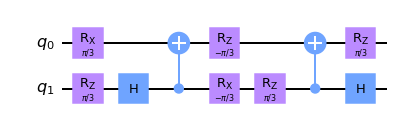

In [3]:
trotter_gate(np.pi / 6, to_instruction=False).draw("mpl")

In [4]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

# Parameterize variable t to be evaluated at t=pi later
dt = Parameter('t')
# Convert custom quantum circuit into a gate
Trot_gate = trotter_gate(dt)

# YOUR TROTTERIZATION GOES HERE -- FINISH (end of example)

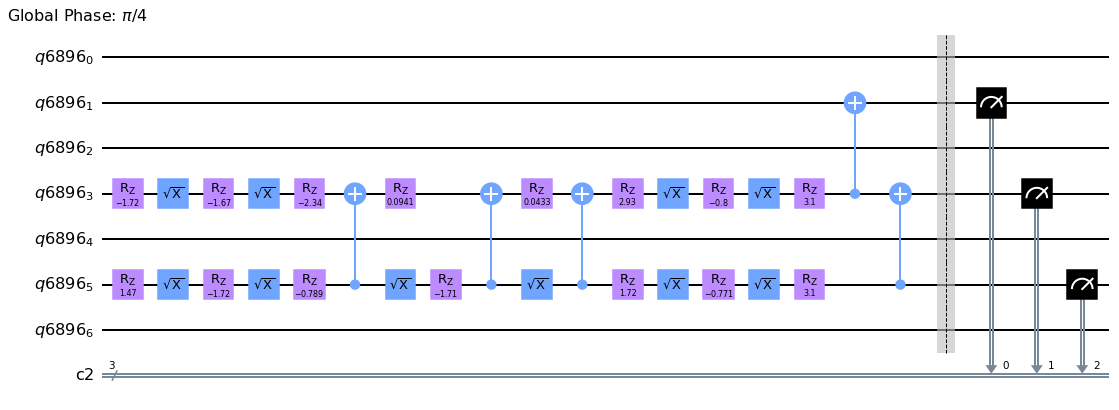

In [16]:
# The final time of the state evolution
target_time = np.pi

# Number of trotter steps
trotter_steps = 15  ### CAN BE >= 4


# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

# Simulate time evolution under H_heis3 Hamiltonian
for _ in range(trotter_steps):
    qc.append(Trot_gate, [qr[3], qr[5]])

qc.cx(qr[3], qr[1])
qc.cx(qr[5], qr[3])

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.bind_parameters({dt: target_time/trotter_steps})
t3_qc = transpile(qc, optimization_level=3, basis_gates=["sx", "cx", "rz"])

# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(t3_qc, [qr[1], qr[3], qr[5]])

# Display circuit for confirmation
# st_qcs[-1].decompose().draw()  # view decomposition of trotter gates
st_qcs[-1].draw("mpl")  # only view trotter gates

In [23]:
shots = 8192
reps = 8

# WE USE A NOISELESS SIMULATION HERE
from qiskit.test.mock import FakeJakarta
backend = FakeJakarta()
# backend = Aer.get_backend("qasm_simulator")

jobs = []
for _ in range(reps):
    # execute
    job = execute(st_qcs, backend, shots=shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 6172bd3c-00b8-473c-b89a-196b2b2cbd12
Job ID becbe0c4-93ca-40de-ba7a-f1f8946899f1
Job ID 4320951f-dbe2-4277-9cb1-8817c8e55a66
Job ID 0f53004d-bb4a-4513-99fd-5a6d15551362
Job ID ce933013-49a1-46d1-b5fe-5b3d0b940f1c
Job ID 2b4dd8e1-9a5b-492d-b49c-38b2289a6c68
Job ID 89d335b3-94bd-4359-a22c-a6cead7f62c6
Job ID 7ab70e9d-5dce-478d-b1ef-458fd7273de2


In [24]:
jobs[0].result().get_counts()[-1]

{'010': 383,
 '000': 210,
 '110': 6812,
 '001': 18,
 '100': 248,
 '101': 200,
 '111': 83,
 '011': 238}

In [25]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

In [26]:
# Compute tomography fidelities for each repetition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.8305 ± 0.0023


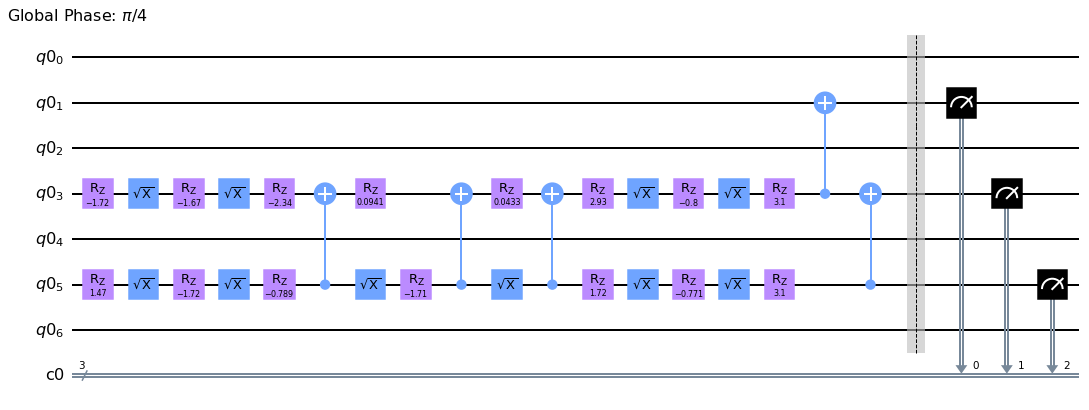

In [14]:
transpile(st_qcs[-1], optimization_level=3, basis_gates=["sx", "rz", "cx"]).draw("mpl")

# Investigate the depth

In [49]:
from qiskit.compiler import transpile

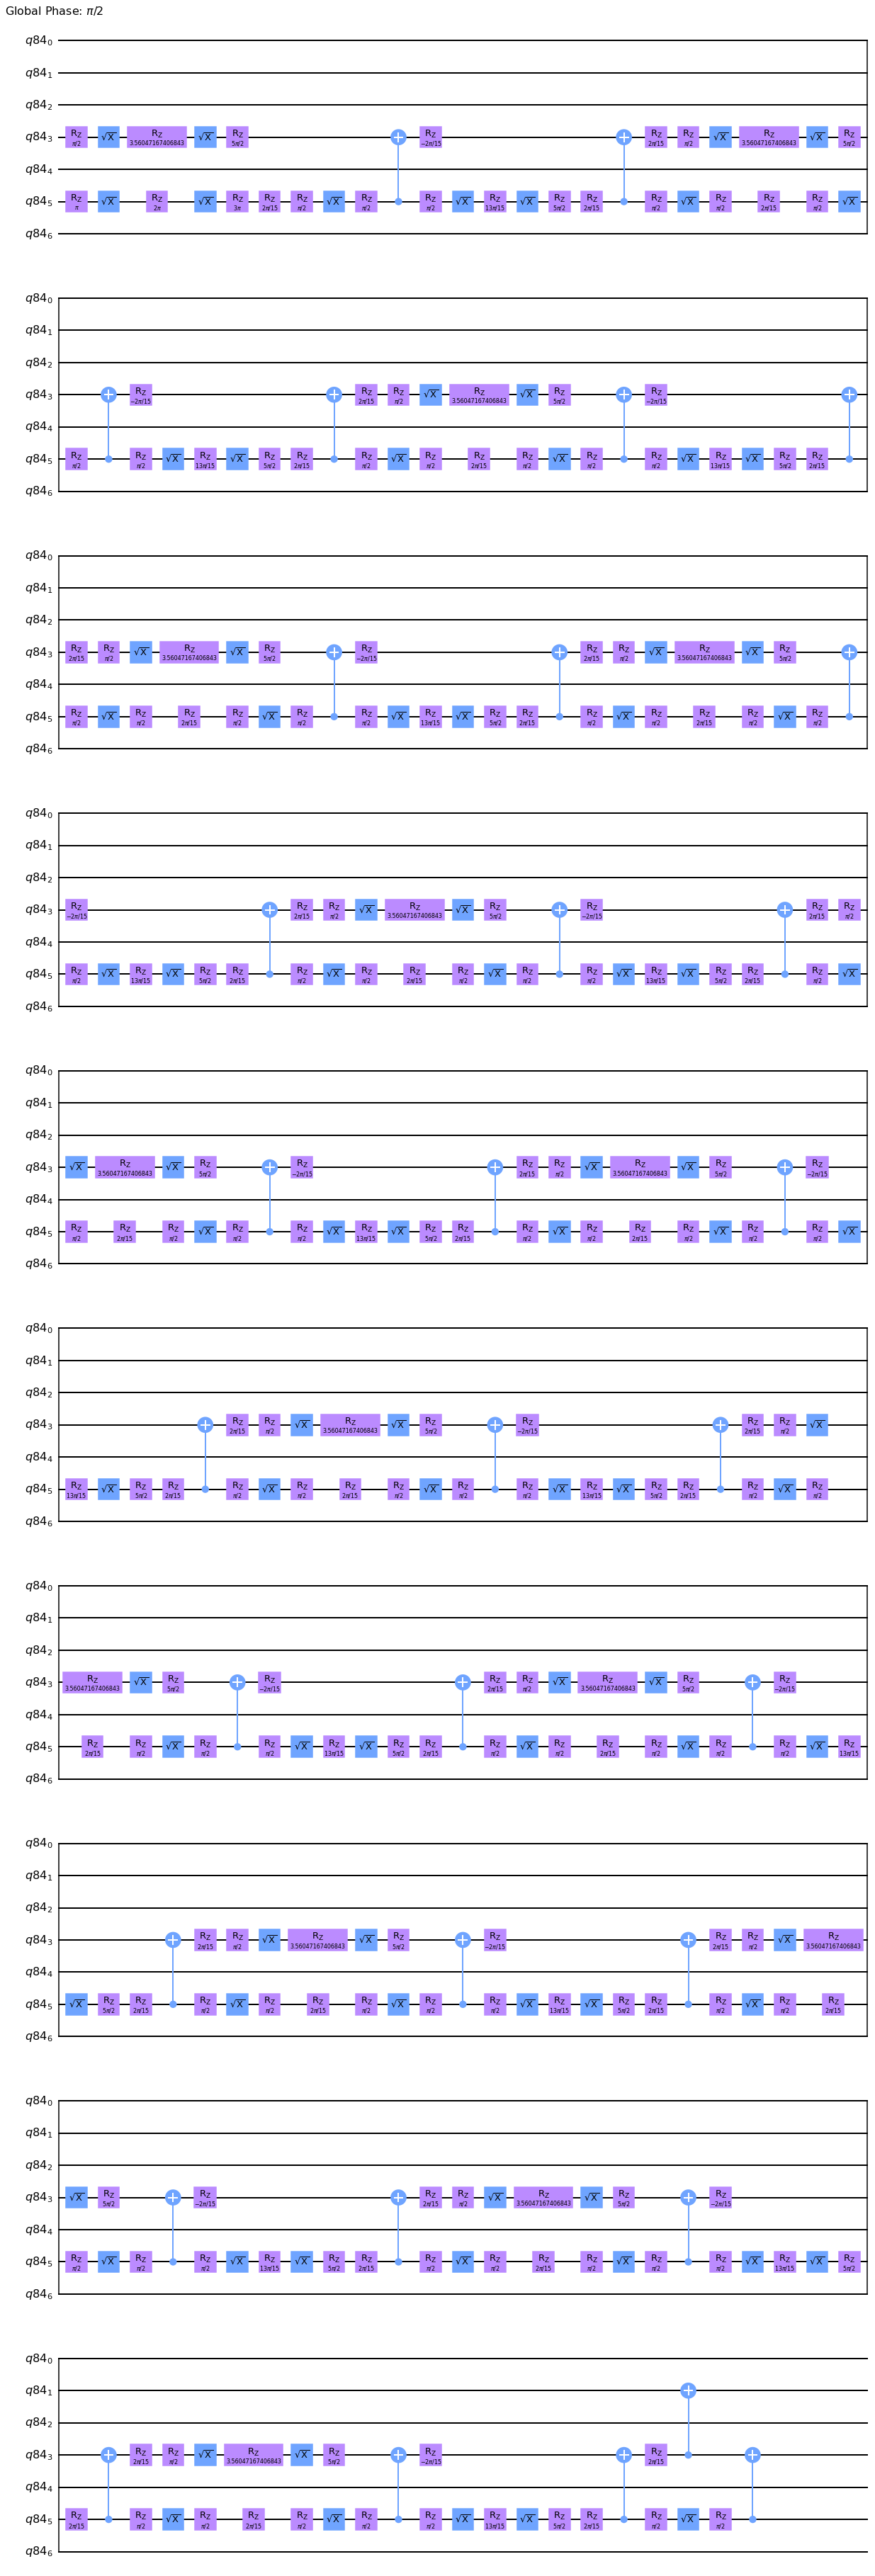

In [82]:
t_qc = transpile(qc, optimization_level=0, basis_gates=["sx","rz","cx"])
t_qc.draw("mpl")

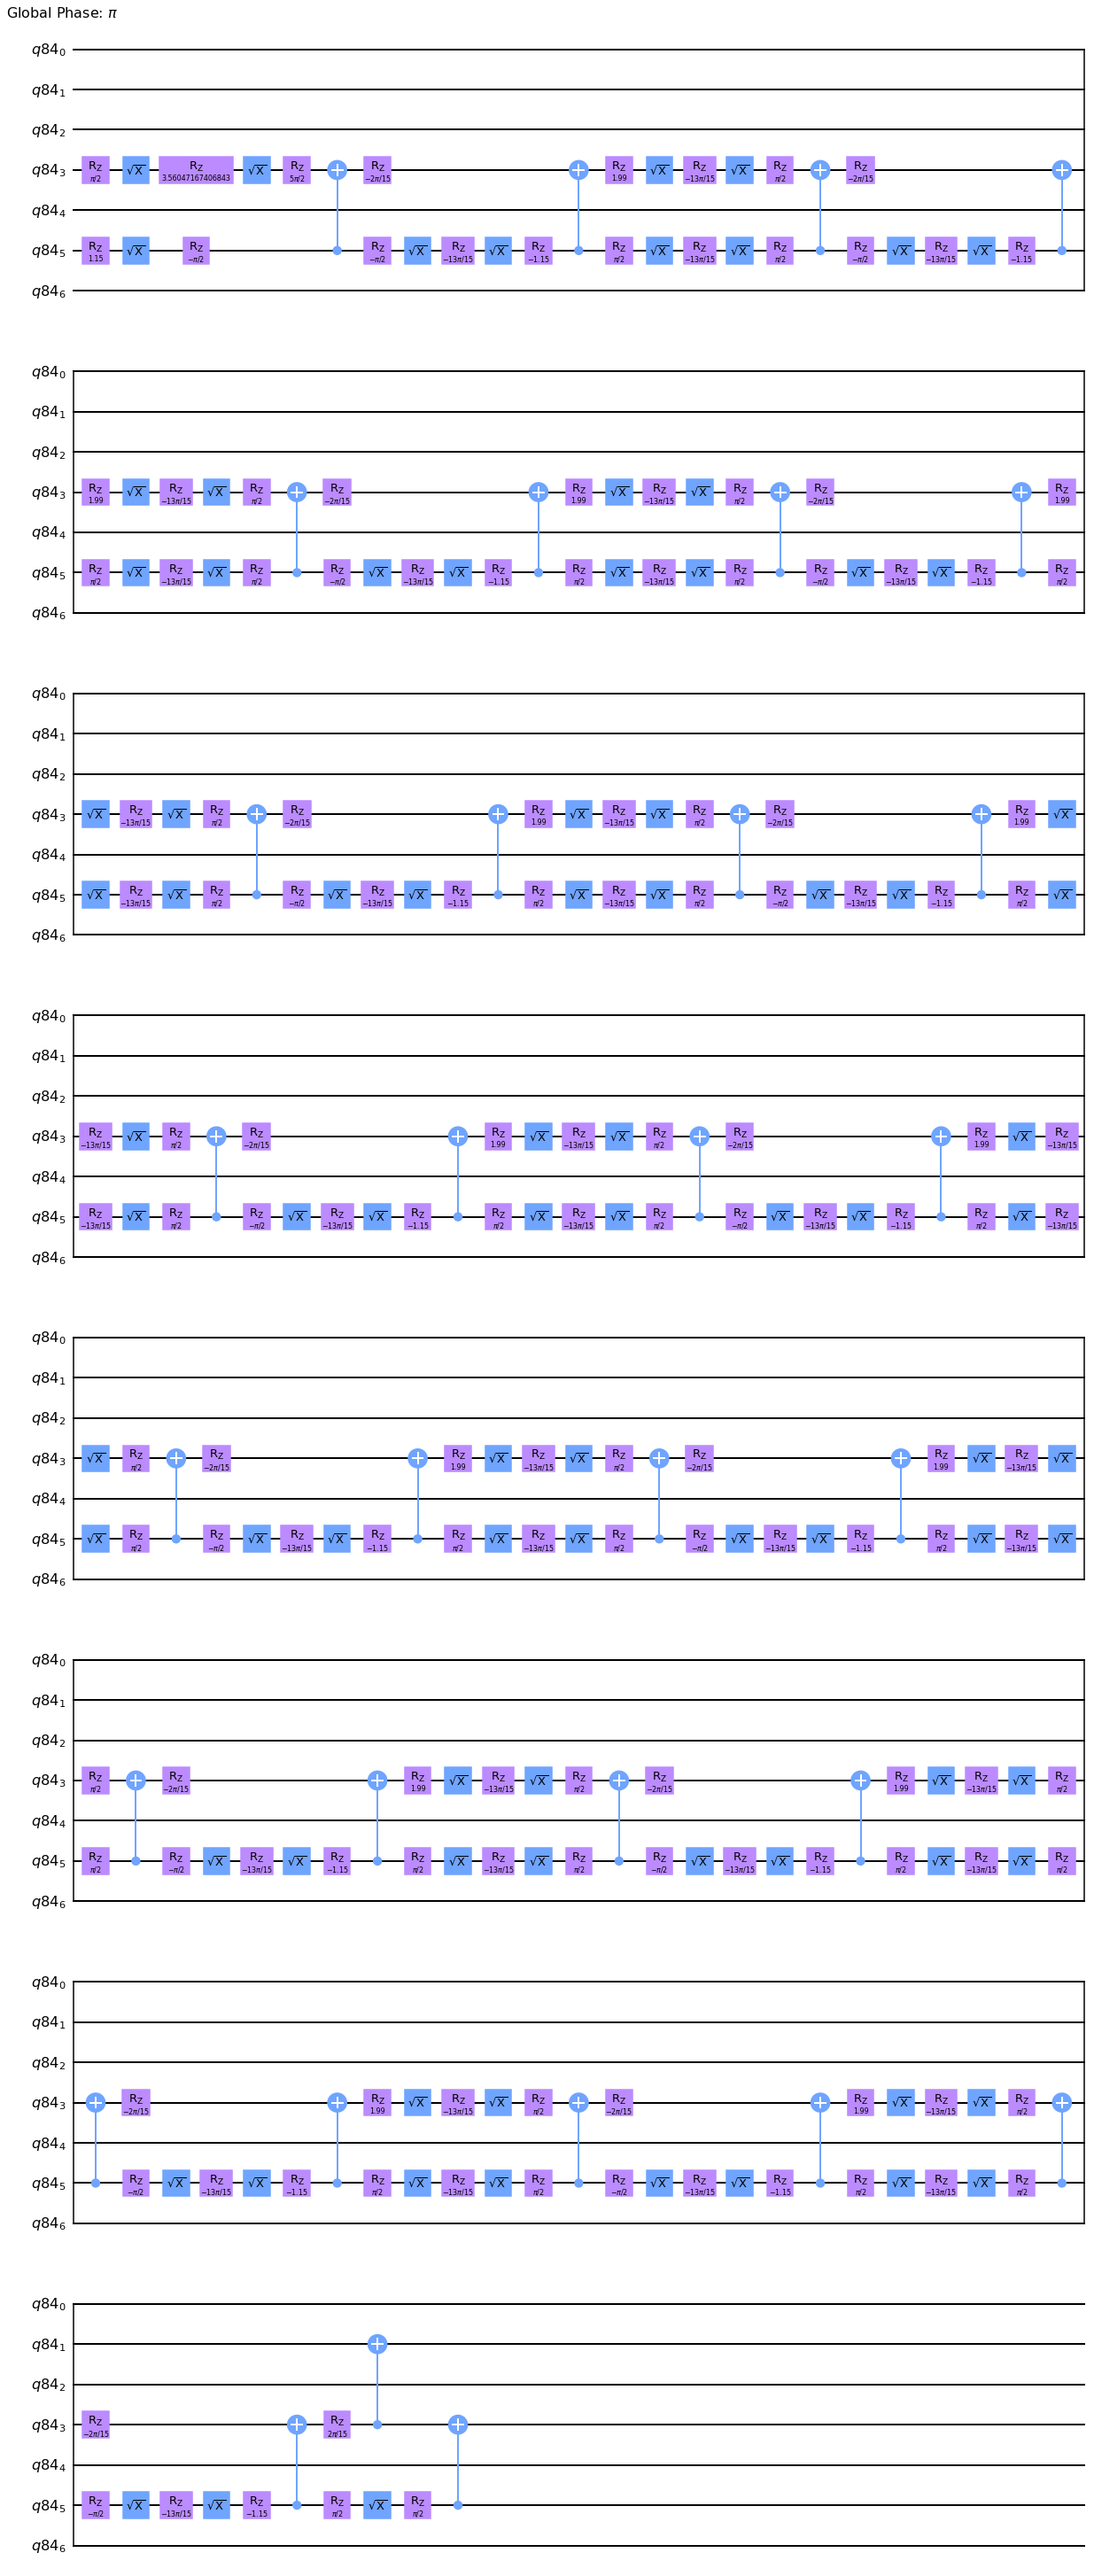

In [83]:
t_qc = transpile(qc, optimization_level=1, basis_gates=["sx","rz","cx"])
t_qc.draw("mpl")

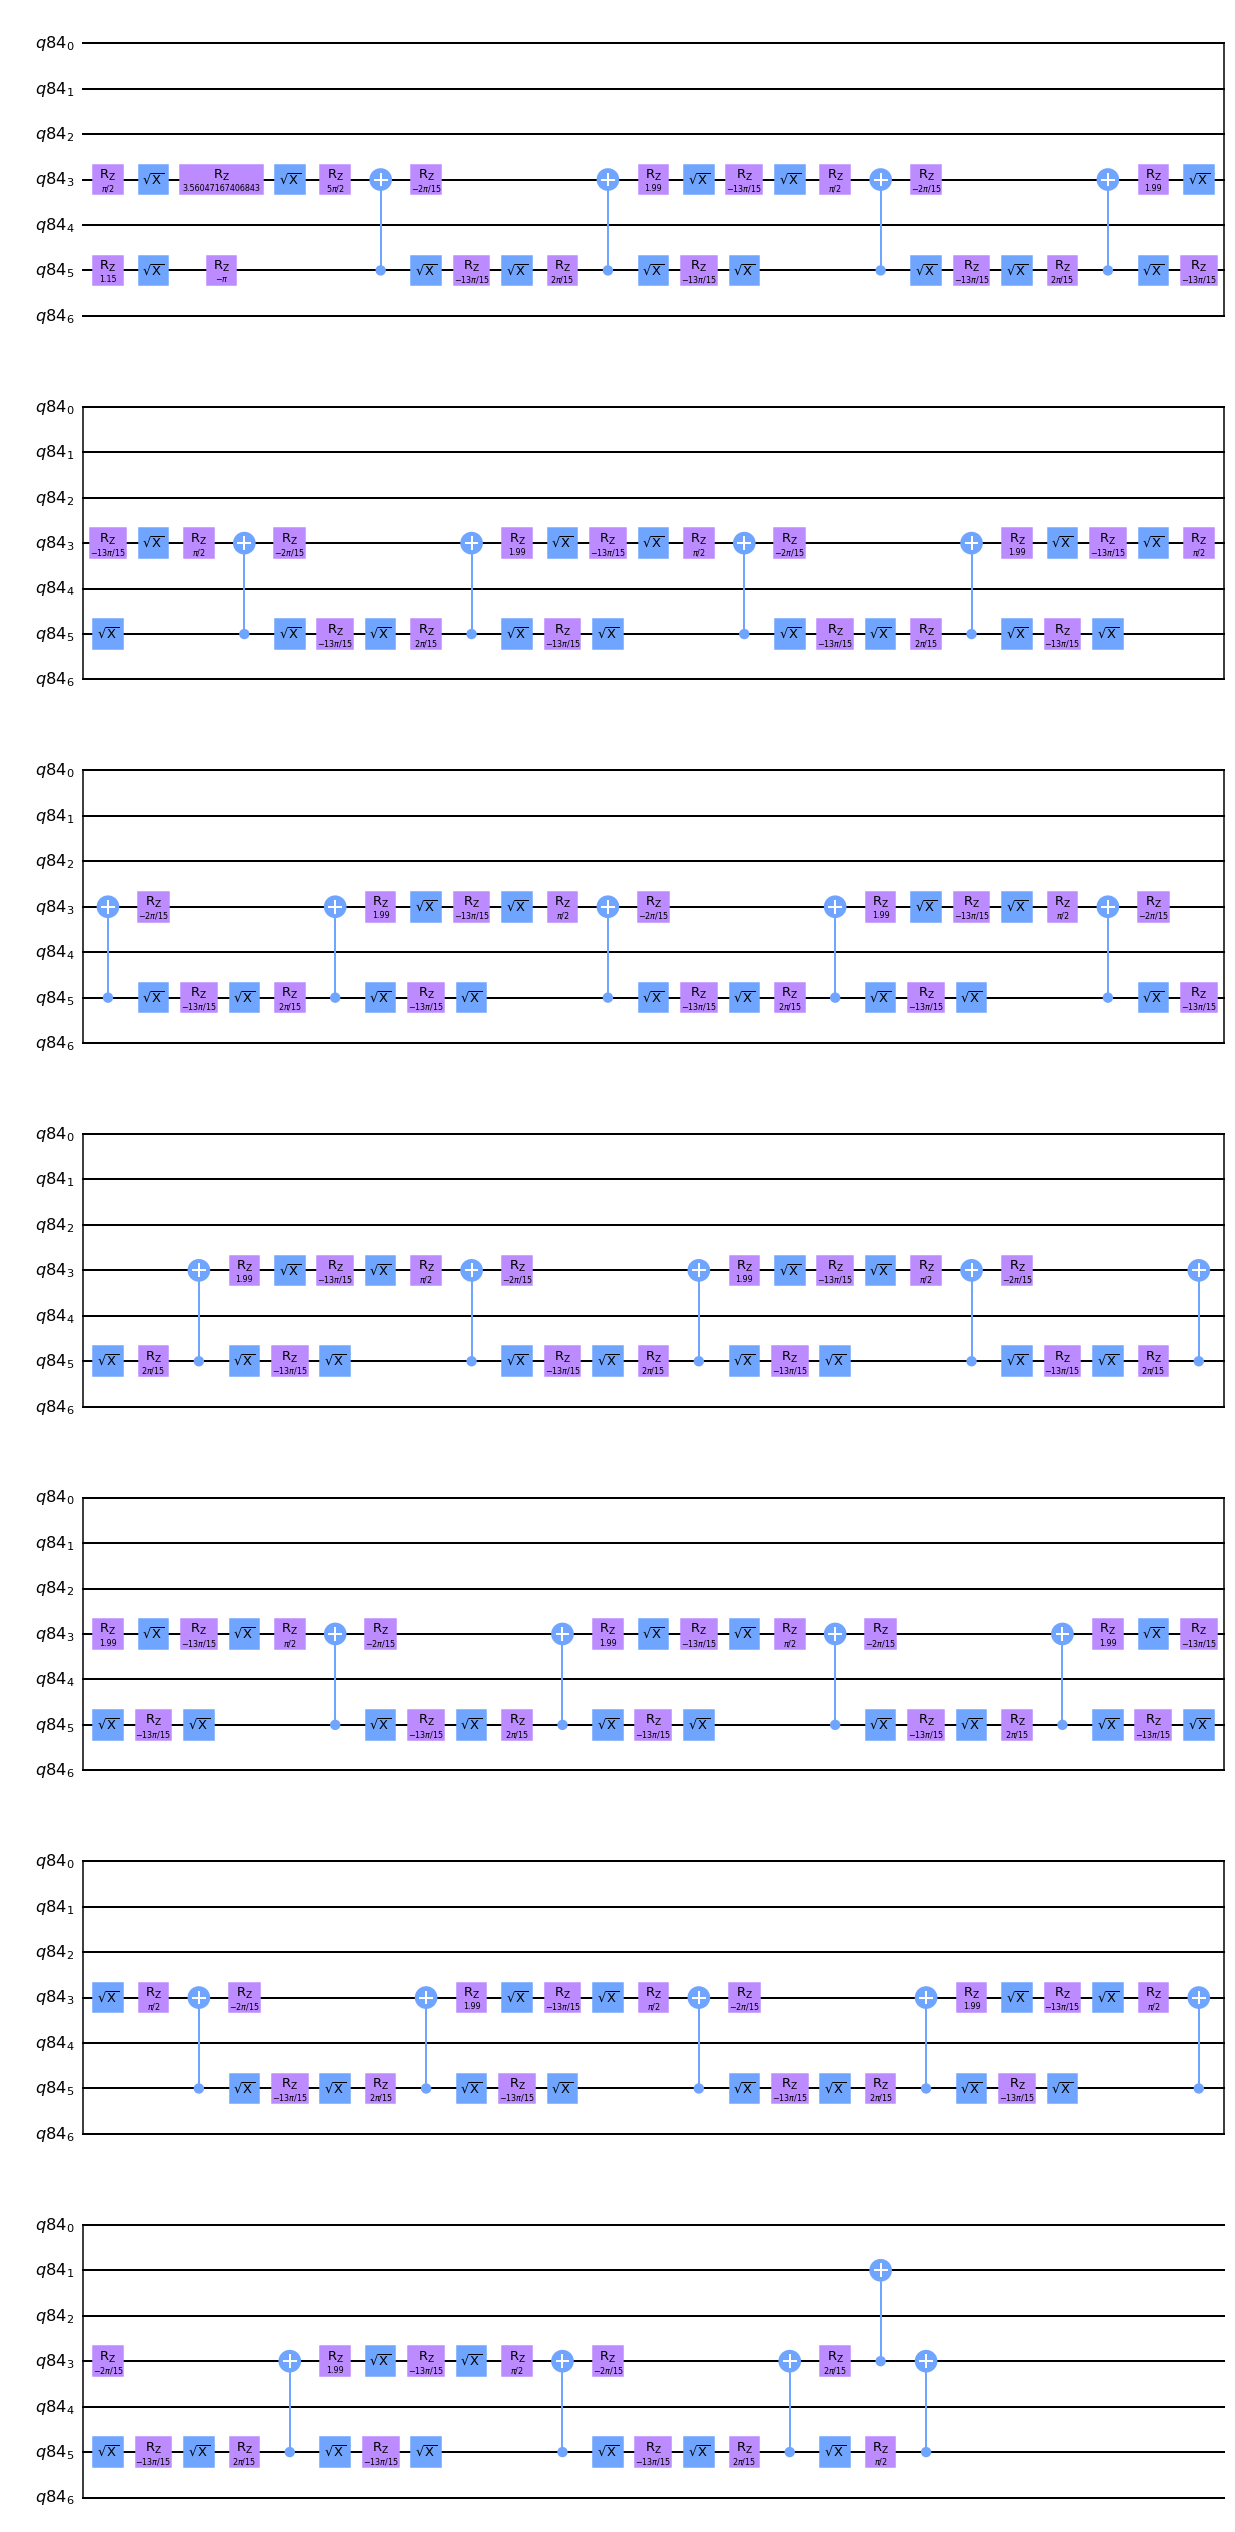

In [84]:
t_qc = transpile(qc, optimization_level=2, basis_gates=["sx","rz","cx"])
t_qc.draw("mpl")

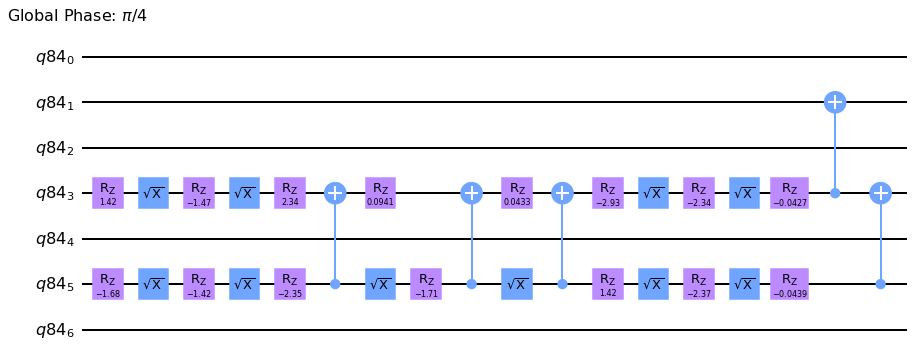

In [85]:
t_qc = transpile(qc, optimization_level=3, basis_gates=["sx","rz","cx"])
t_qc.draw("mpl")